# Tennis - Encoder Decoder  | Train

In [1]:
import sys
sys.path.append('..')
from time import time
from util import *
from util.parser import *
from util.img_kit import *
from util.notebook_display import *
from util.numeric_ops import *
from util.tf_ops import *

from IPython import display
import numpy as np
from scipy import ndimage
from scipy import misc
from os import walk
import os
import tensorflow as tf
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

/Users/Rishabh/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Collect an ensemble of box data

In [28]:
def convert_to_float(collection):
    return [x/255 for x in collection]

In [29]:
def get_processed_collection(folder):
    collection = get_collection(folder)
    collection = convert_to_float(collection)
    collection = center_collections(collection)
    return collection

In [30]:
train_collection = get_processed_collection("../data/data/walking/64x64x3/greenscreen_train")
total_train = sum([x.shape[0] for x in train_collection])
print("\nAfter Augmentation: img_collections has {} collections, {} images in total".format(len(train_collection), total_train))

walk_greenscreen_1
walk_greenscreen_3
walk_greenscreen_2
walk_greenscreen_6

After Augmentation: img_collections has 4 collections, 5937 images in total


In [58]:
test_collection = get_processed_collection("../data/data/walking/64x64x3/greenscreen_train")
total_test = sum([x.shape[0] for x in test_collection])
print("\nAfter Augmentation: img_collections has {} collections, {} images in total".format(len(test_collection), total_test))

walk_greenscreen_1
walk_greenscreen_3
walk_greenscreen_2
walk_greenscreen_6

After Augmentation: img_collections has 4 collections, 5937 images in total


## Sample from Collection

In [33]:
def sample(collection, batch_size = 8, gap = 1):
    """
    Input:
        collection: [img_data] - list of ndarray
    Output:
        before_imgs, after_img, mid_imgs -  [batch size, 32, 32]
    """
    assert gap%2==1, "Gap must be odd !"      
    np.random.shuffle(collection)
    # get average number of training for each class
    n_collection = len(collection)
    num_per_collection = [x.shape[0] for x in collection]
    avg_num_per_class = int(np.ceil(batch_size/n_collection))
    # before-index for each class
    before_ind = []
    for i, imgs in enumerate(collection):
        try:
            s = np.random.choice(range(num_per_collection[i] - gap - 1), avg_num_per_class, replace=False)
            before_ind.append(s)
        except: # if not enough in this class
            before_ind.append(np.array([]))
    # after-index for each class
    after_ind = [x+gap+1 for x in before_ind]
    # mid-index for each class
    mid_ind = [x+(gap+1)//2 for x in before_ind]
    
    selected_classes = [i for i in range(n_collection) if before_ind[i].shape[0]>0]
    before_imgs = np.concatenate([collection[i][before_ind[i]] for i in selected_classes], axis = 0)
    after_imgs = np.concatenate([collection[i][after_ind[i]] for i in selected_classes], axis = 0)
    mid_imgs = np.concatenate([collection[i][mid_ind[i]] for i in selected_classes], axis = 0)
    
    before_imgs = before_imgs[:batch_size]
    mid_imgs = mid_imgs[:batch_size]
    after_imgs = after_imgs[:batch_size]
    return before_imgs, after_imgs, mid_imgs


def sample_train(batch_size = 8, gap = 1): return sample(train_collection, batch_size, gap = gap)

def sample_test(batch_size = 8, gap = 1):  return sample(test_collection, batch_size, gap)

## Take a look at Training data

Range of Image Piece Value: [-1.0, 1.0]
Before: (4, 32, 32, 3)
After:  (4, 32, 32, 3)
Mid:    (4, 32, 32, 3)


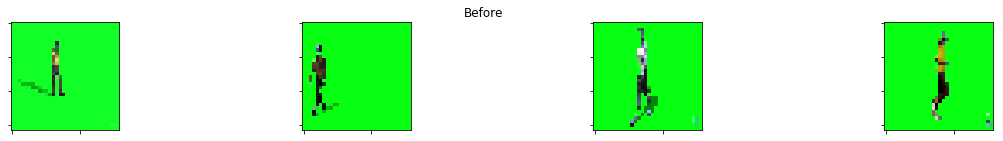

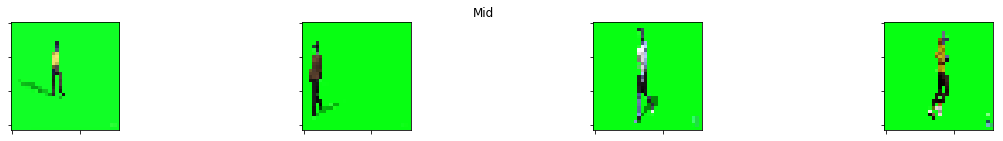

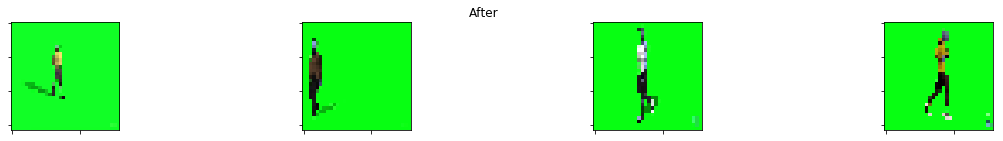

In [34]:
def show_sample_train(batch_size, gap):
    before, after, mid = sample_train(batch_size=batch_size, gap=gap)
    print("Range of Image Piece Value: [{}, {}]".format(np.min(mid), np.max(mid)))
    print("Before: {}".format(before.shape))
    print("After:  {}".format(after.shape))
    print("Mid:    {}".format(mid.shape))
    size = (20, 2)
    plot_images(before, size, "Before")
    plot_images(mid, size, "Mid")
    plot_images(after, size, "After")
    
show_sample_train(batch_size = 4, gap = 9)

## Target

### Gap: How harsh do you want to train the model?

In [35]:
gap = 1

### Model Capacity

In [36]:
feature_channel = 128

## Param

In [37]:
batch_size = 32

learning_rate = 1e-4

beta = 0.9 # defalut 0.9 for adam
num_iteration = 2000

model_save_path = "trained_model/tennis/{}/".format(time())

## Create Directory for Model to be saved

In [38]:
try:
    os.mkdir(model_save_path)
    print("Model to be saved at {}".format(model_save_path))
except:
    assert "Cannot create save folder!"

### Leaky Relu

In [39]:
def leaky_relu(x): return tf.maximum(x, alpha * x)

# Encoder

In [40]:
def encode(img, is_training=True):
    """
    Input:
        batch size of img
    Output:
        batch size of feature [batch_size, 20, 32, feature_channel]
    """
    x = img
    
    x = tf.layers.conv2d(x, filters = 48, kernel_size=8, strides=2, padding='same', activation=tf.nn.relu)
    
    x = tf.layers.conv2d(x, filters = 48, kernel_size=5, strides=2, padding='same', activation=tf.nn.relu)
    
    x = tf.layers.conv2d(x, filters = 48, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)

    x = tf.layers.conv2d(x, filters = 48, kernel_size=3, strides=1, padding='same', activation=tf.nn.relu)

    x = tf.layers.conv2d(x, filters = 48, kernel_size=2, padding='same', activation=tf.nn.relu)
    
    x = tf.layers.conv2d(x, filters = feature_channel, kernel_size=2, padding='same', activation=tf.nn.relu)
    return x

# Decoder

In [41]:
def decode(feature1, feature2, is_training=True):
    """
    Input:
        batch size of feature [batch_size, 20, 32, feature_channel]
    Output:
        batch size of img [batch_size, 160, 256, 3]
    """
    x = tf.concat([feature1, feature2], axis=3)

    x = tf.layers.conv2d(x, filters = 84, kernel_size=3, padding='same', activation=tf.nn.relu)
    x = tf.layers.conv2d_transpose(x, filters=48, kernel_size=5, strides=2, activation=tf.nn.relu, padding='same')
    x = tf.layers.conv2d_transpose(x, filters=48, kernel_size=7, strides=2, activation=tf.nn.relu, padding='same')
    x = tf.layers.conv2d_transpose(x, filters=48, kernel_size=4, strides=2, activation=tf.nn.relu, padding='same')
    x = tf.layers.conv2d_transpose(x, filters=48, kernel_size=3,  strides=1, activation=tf.nn.tanh, padding='same')
    x = tf.layers.conv2d_transpose(x, filters=24, kernel_size=2,  strides=1, activation=tf.nn.tanh, padding='same')
    img = tf.layers.conv2d_transpose(x, filters=3, kernel_size=2,  strides=1, activation=tf.nn.tanh, padding='same')
    return img

## Generator

In [42]:
def generate(x1, x2,  is_training=True):
    with tf.variable_scope("generator") as scope:
        feature1, feature2 = encode(x1, is_training), encode(x2, is_training)
        img = decode(feature1, feature2, is_training)
        return img

### Loss

In [43]:
def content_loss(x, gd):
    return tf.norm(x-gd)

### Get a Batch Generation

In [44]:
def get_generattion(before, after, mid):
    dic = {batch_before: before, batch_after: after, batch_mid: mid, is_training: False}
    gen_batch = sess.run(G_batch, dic)
    return gen_batch

### Solver

In [45]:
def get_solver(learning_rate=1e-3, beta1=0.5):
    return tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)

### Report Loss = loss_computed * 255 / batch_size

In [46]:
def report_loss(name, num_run = 100, gap = 3, batch_size = batch_size):
    losses = []
    for _ in range(num_run):
        if name == "train": before, after, mid = sample_train(batch_size, gap)
        elif name == "val": before, after, mid = sample_dev(batch_size, gap)
        else:                before, after, mid = sample_test(batch_size, gap) 
        loss = sess.run(G_loss, \
                        feed_dict = {batch_before: before, batch_after: after, batch_mid: mid, is_training: False})
        losses.append(loss)
    return scale_loss(np.mean(losses) / batch_size, 2)

## Computational Graph

In [47]:
tf.reset_default_graph()
batch_mid        = tf.placeholder(tf.float32, [None, 32, 32, 3], "batch_mid")
batch_before     = tf.placeholder(tf.float32, [None, 32, 32, 3], "batch_before")
batch_after      = tf.placeholder(tf.float32, [None, 32, 32, 3], "batch_after")
is_training      = tf.placeholder(tf.bool, (), name = "is_training")

# alpha   = tf.Variable(0., "alpha") # parameter for leaky relu
G_batch = generate(batch_before, batch_after)



G_loss = content_loss(G_batch, batch_mid)
G_solver = get_solver(learning_rate, beta)

G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

# add to saver
#tf.add_to_collection('G_batch', G_batch)
#tf.add_to_collection('loss', G_loss)

In [48]:
def train(sess, G_step, G_loss, batch_size, num_iteration, plot_every = 400, \
          show_loss_every=400, nPlot=6, num_plot = 6, save_every = 1000):
    g_losses = []
    saver = tf.train.Saver()
    for i in range(1, num_iteration+1):
        # get a sample
#         gap = np.random.choice([1,3,5,7,9])
        real_before, real_after, real_mid = sample_train(batch_size, gap)
        dic = {batch_mid: real_mid, batch_before: real_before, batch_after: real_after, is_training: True}
        
        _, G_loss_curr = sess.run([G_train_step, G_loss], dic)
        G_loss_curr = scale_loss(G_loss_curr/batch_size, 2)# tweek loss to match report loss
        
        g_losses.append(G_loss_curr)
    
        if i%show_loss_every ==0:
            print("Iteration {}:  G_loss = {} | Gap = {}".format(i, G_loss_curr, gap))
            
        if i%plot_every == 0:
            real_before, real_after, real_mid = sample_train(num_plot, gap)
            gen_batch_test = sess.run(G_batch, feed_dict=\
                                      {batch_before: real_before, batch_after: real_after, is_training: False})
            plot_batch_images(gen_batch_test[:nPlot], (16, 2) , "Iteration: {} | gap = {}".format(i, gap))
        #if i%save_every == 0:
            #saver.save(sess, model_save_path, global_step = i)  
    #save_learning_curve(iterations = list(range(1, num_iteration+1)), loss = g_losses, \
                            #save_path = "output/learning_curve/Tennis-{}".format(time()))
    return g_losses

# Train !

Iteration 50:  G_loss = 336.3400465250015 | Gap = 1


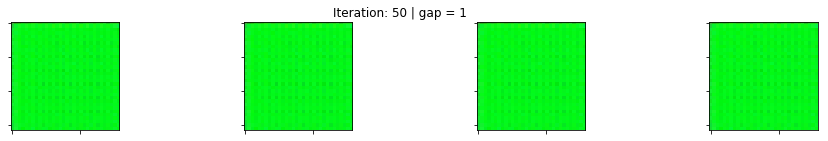

Iteration 100:  G_loss = 333.8972336053848 | Gap = 1


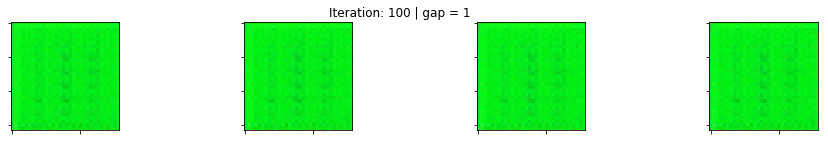

Iteration 150:  G_loss = 346.12871646881104 | Gap = 1


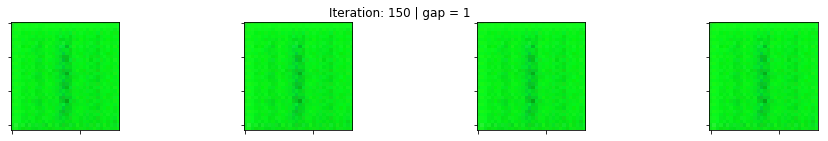

Iteration 200:  G_loss = 397.4452668428421 | Gap = 1


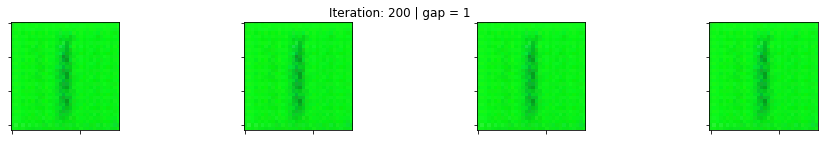

Iteration 250:  G_loss = 392.7600574493408 | Gap = 1


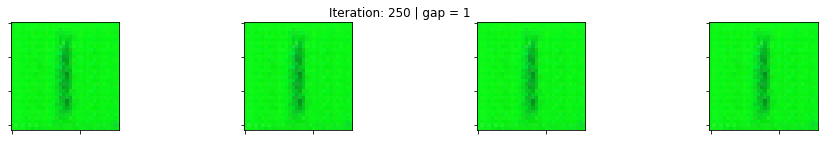

Iteration 300:  G_loss = 384.6776479482651 | Gap = 1


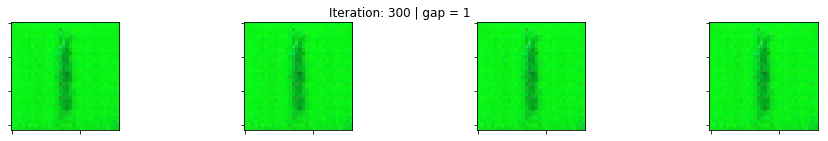

Iteration 350:  G_loss = 328.27955424785614 | Gap = 1


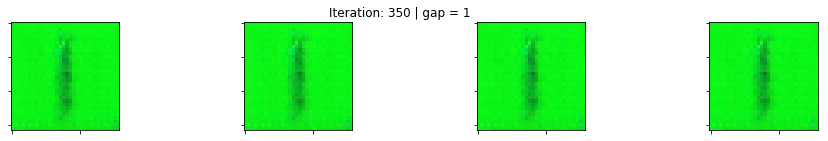

Iteration 400:  G_loss = 298.3715718984604 | Gap = 1


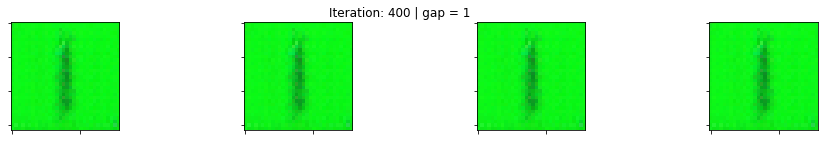

Iteration 450:  G_loss = 305.7127171754837 | Gap = 1


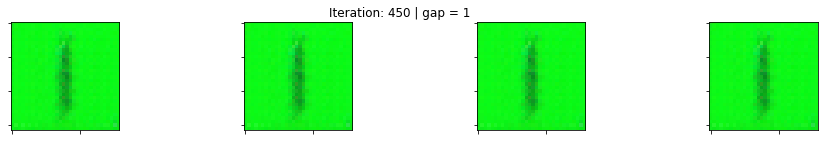

Iteration 500:  G_loss = 278.8701367378235 | Gap = 1


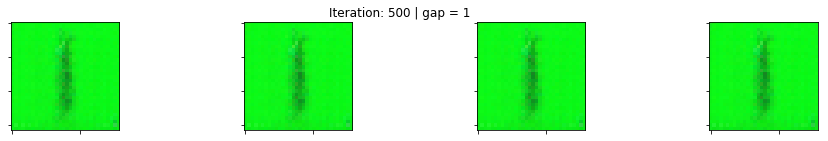

Iteration 550:  G_loss = 284.59609508514404 | Gap = 1


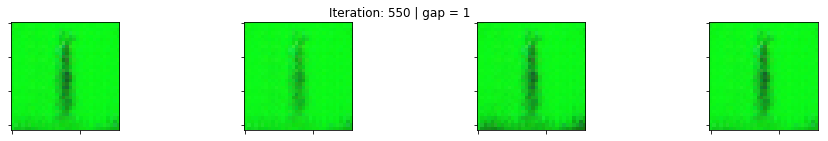

Iteration 600:  G_loss = 285.1484942436218 | Gap = 1


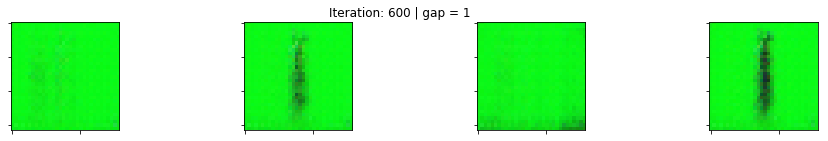

Iteration 650:  G_loss = 276.9001704454422 | Gap = 1


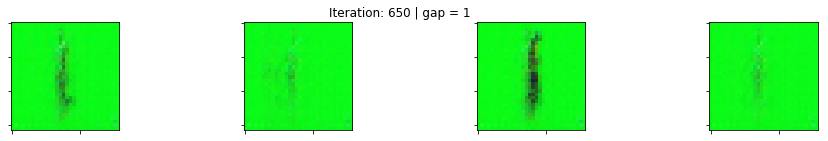

Iteration 700:  G_loss = 249.97513443231583 | Gap = 1


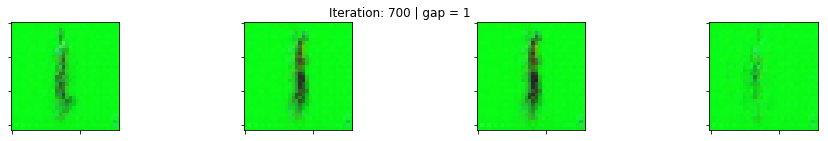

Iteration 750:  G_loss = 234.41332787275314 | Gap = 1


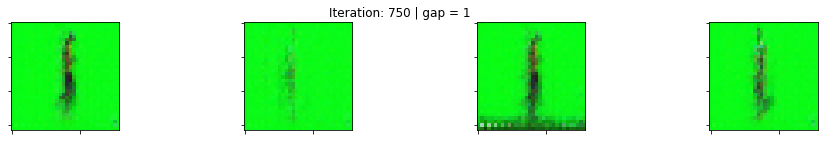

Iteration 800:  G_loss = 233.79548102617264 | Gap = 1


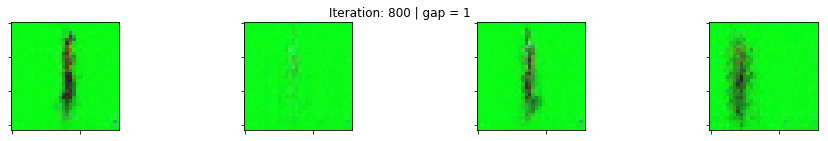

Iteration 850:  G_loss = 231.89237594604492 | Gap = 1


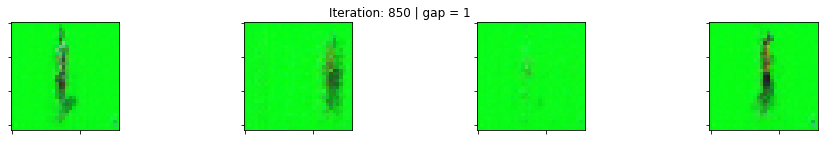

Iteration 900:  G_loss = 225.70945411920547 | Gap = 1


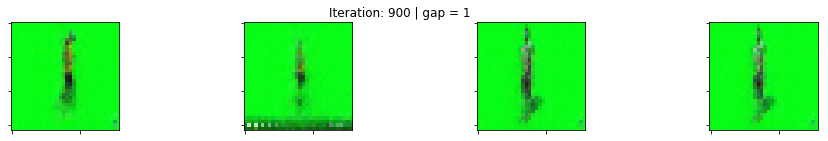

Iteration 950:  G_loss = 220.92722833156586 | Gap = 1


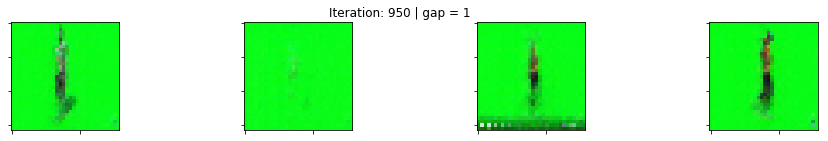

Iteration 1000:  G_loss = 230.58418214321136 | Gap = 1


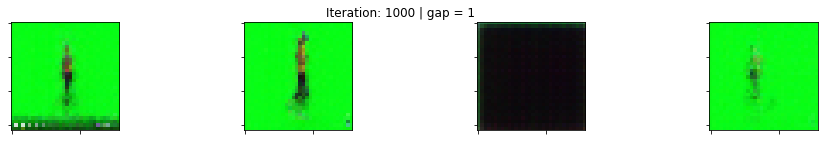

Iteration 1050:  G_loss = 202.93476819992065 | Gap = 1


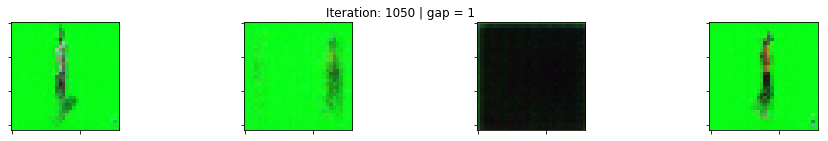

Iteration 1100:  G_loss = 202.61005282402039 | Gap = 1


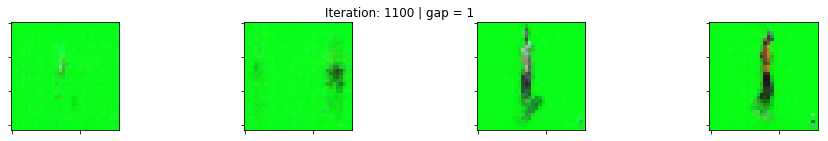

Iteration 1150:  G_loss = 242.15541243553162 | Gap = 1


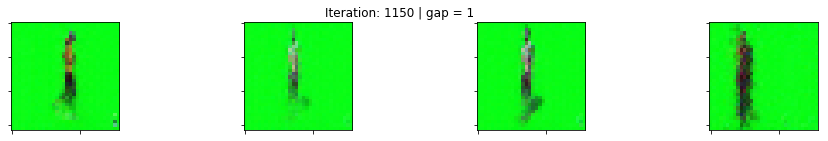

Iteration 1200:  G_loss = 209.54197525978088 | Gap = 1


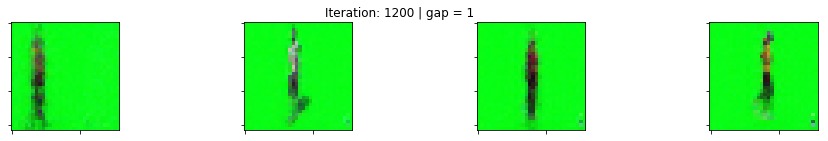

Iteration 1250:  G_loss = 206.26457512378693 | Gap = 1


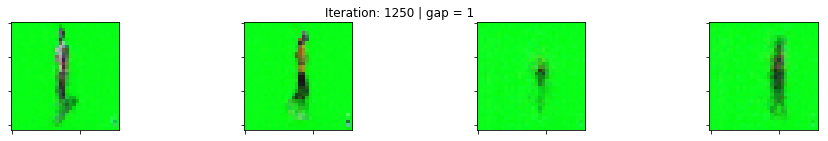

Iteration 1300:  G_loss = 194.61630016565323 | Gap = 1


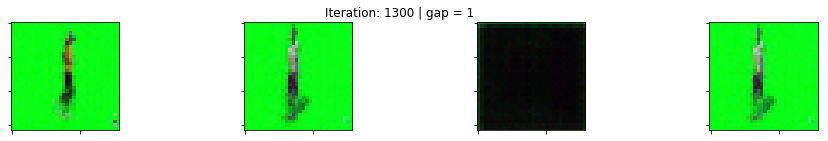

Iteration 1350:  G_loss = 199.69231098890305 | Gap = 1


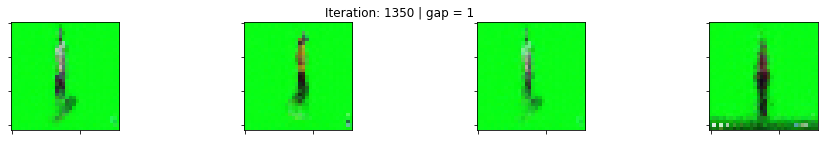

Iteration 1400:  G_loss = 221.13399803638458 | Gap = 1


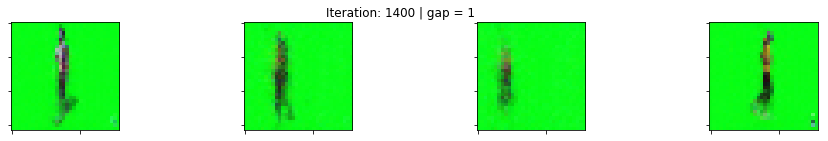

Iteration 1450:  G_loss = 194.3080759048462 | Gap = 1


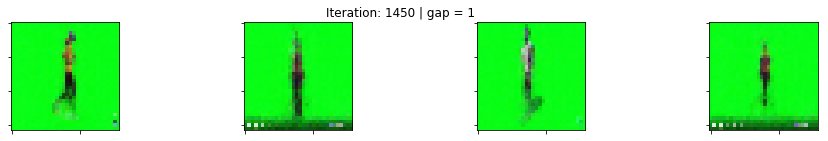

Iteration 1500:  G_loss = 205.16774117946625 | Gap = 1


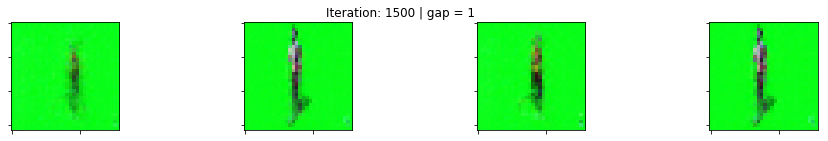

Iteration 1550:  G_loss = 187.87597864866257 | Gap = 1


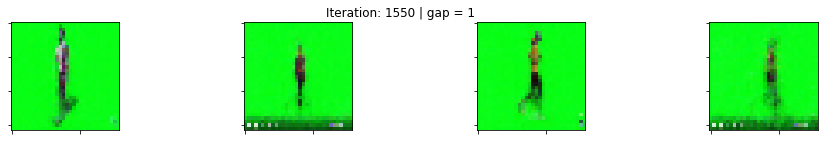

Iteration 1600:  G_loss = 205.39636731147766 | Gap = 1


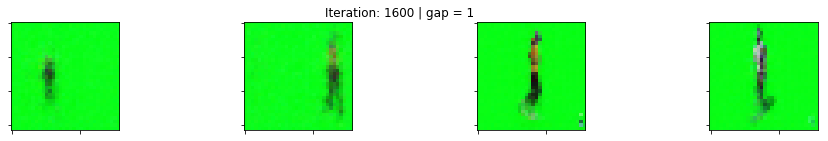

Iteration 1650:  G_loss = 188.56740474700928 | Gap = 1


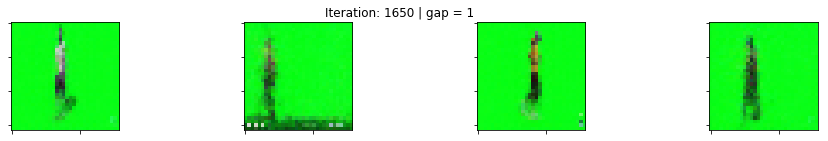

Iteration 1700:  G_loss = 208.58719289302826 | Gap = 1


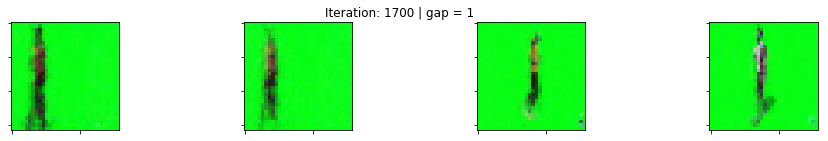

Iteration 1750:  G_loss = 188.72617542743683 | Gap = 1


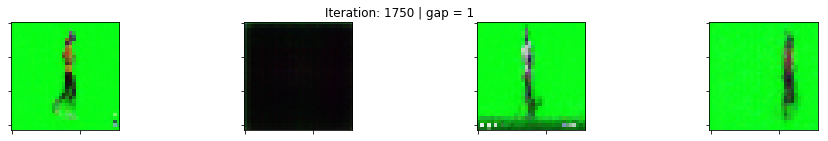

Iteration 1800:  G_loss = 215.55329829454422 | Gap = 1


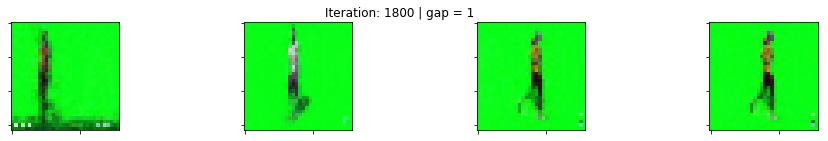

Iteration 1850:  G_loss = 194.5118209719658 | Gap = 1


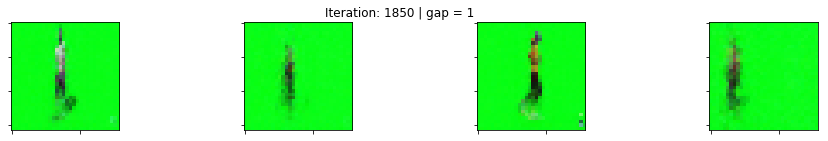

Iteration 1900:  G_loss = 183.9142656326294 | Gap = 1


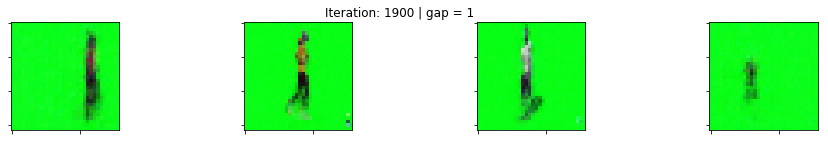

Iteration 1950:  G_loss = 187.1115204691887 | Gap = 1


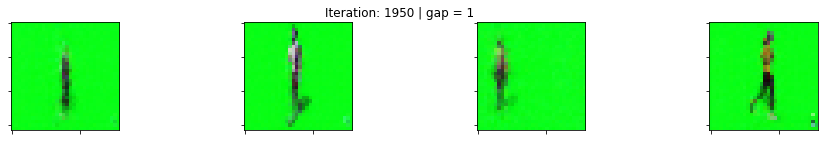

Iteration 2000:  G_loss = 170.925954580307 | Gap = 1


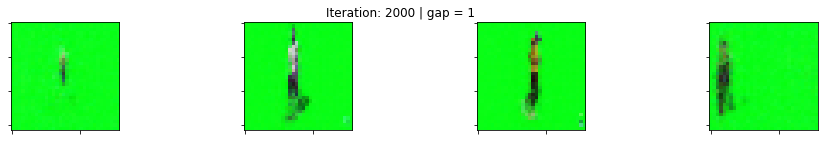

In [49]:
sess = get_session()
sess.run(tf.global_variables_initializer())
g_loss = train(sess, G_train_step, G_loss, batch_size, \
               num_iteration, plot_every = 50, show_loss_every = 50, num_plot=4, save_every = 2000)

## Plot Learning Curve

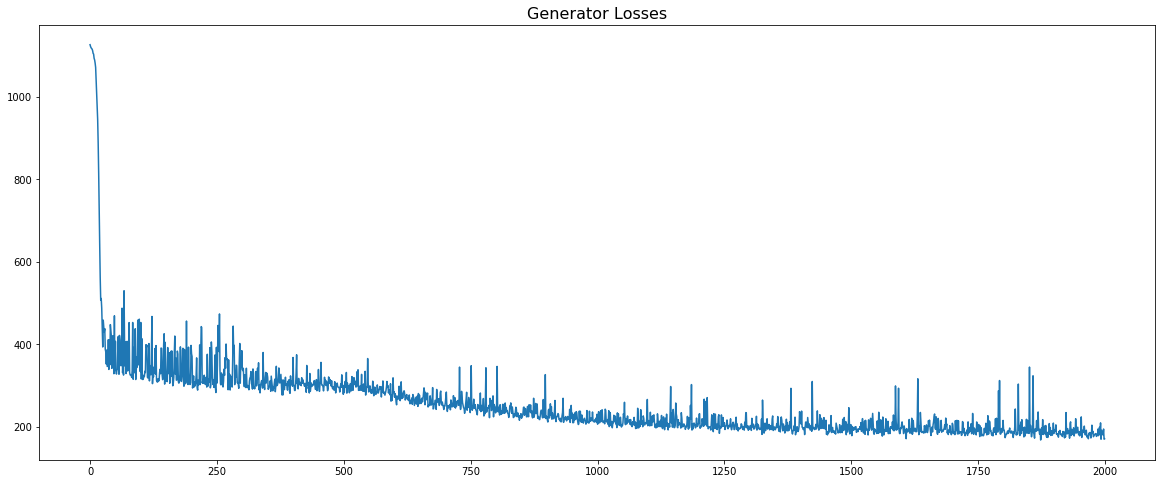

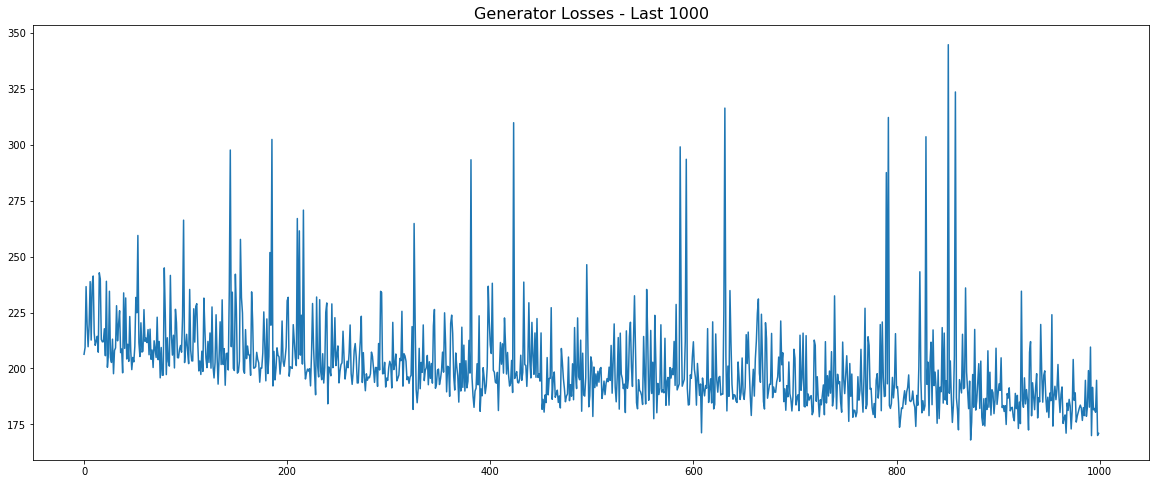

In [50]:
figsize = (20, 8)

plt.figure(figsize=figsize)
plt.plot(g_loss)
plt.title("Generator Losses", fontsize=16)
plt.show()

plt.figure(figsize=figsize)
plt.plot(g_loss[-1000:])
plt.title("Generator Losses - Last 1000", fontsize=16)
plt.show()

# Evaluate !

In [51]:
def show_generations(name, num = 6, gap = 3):
    if name == "train":  before, after, mid = sample_train(num, gap)
    else:                before, after, mid = sample_test(num, gap) 
    
    gen_batch = get_generattion(before, after, mid)
    size = (20, 2)
    plot_images(before, size, "Before")
    plot_images(after, size, "After")
    plot_images(mid, size, "Mid - Real")
    plot_images(gen_batch, size, "Mid - Generated")

## - Evaluate on Training Data

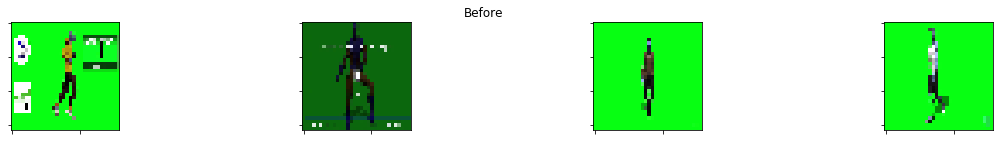

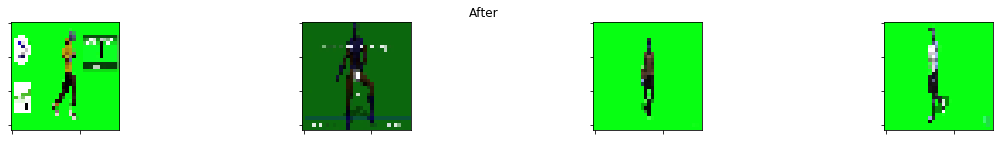

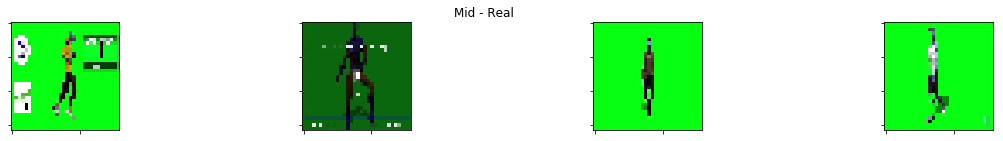

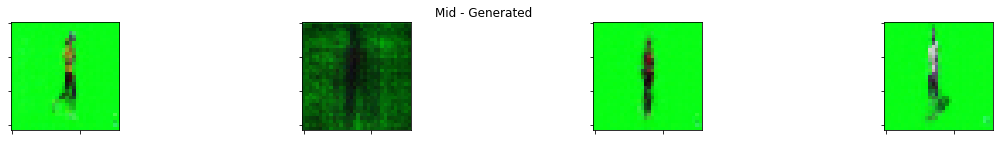

Training Loss = 193.71327102184296


In [67]:
def eval_train(num_show = 8, gap = 3):
    show_generations("train", num_show, gap)
    loss = report_loss("train", 10, gap, batch_size)
    print("Training Loss = {}".format(loss))
    return loss

train_loss = eval_train(num_show = 4, gap = gap)

## - Evaluate on Test Data

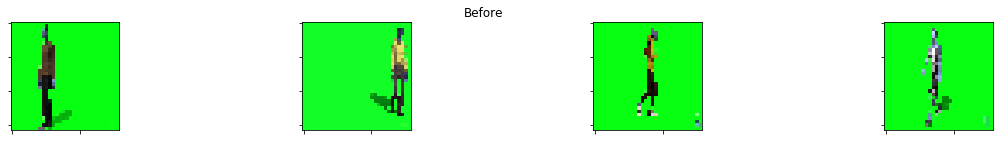

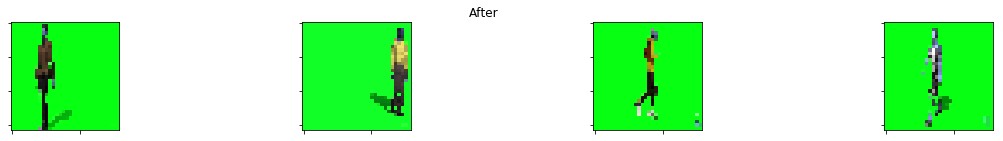

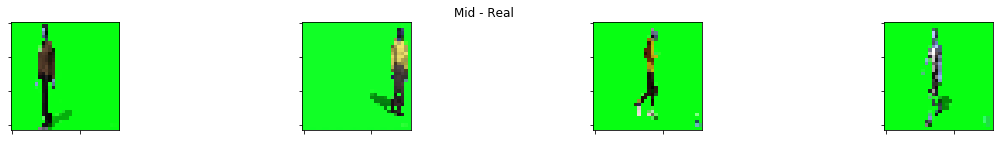

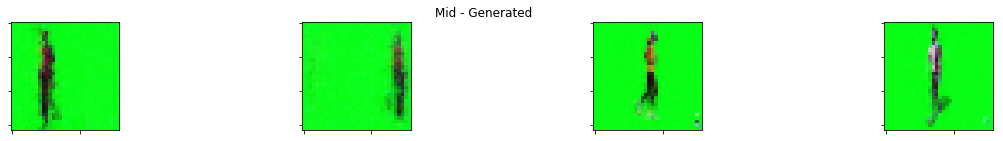

Test Loss = 362.1730363368988


In [65]:
def eval_test(num_show = 6, gap = 3, num_test = 100, batch_size = batch_size):
    show_generations("test", num_show, gap)
    loss = report_loss("test", num_test, gap, batch_size)
    print("Test Loss = {}".format(loss))
    return loss

test_loss = eval_test(num_show = 4, gap=1, batch_size = 8, num_test=10)

## How much overfitting?

In [66]:
print("(Test Loss - Train Loss)/Train Loss = {}".format((test_loss-train_loss)/train_loss))

(Test Loss - Train Loss)/Train Loss = 0.8464882015067176
